In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import math
import scipy.cluster.hierarchy as sch
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
dat = pd.read_csv('datasets_regionalhappy.csv')

In [3]:
dat.head()

,Happiness.Score,Economy..GDP.per.Capita.,Family,Health..Life.Expectancy.,Freedom,Generosity,Trust..Government.Corruption.,Dystopia.Residual
0,7.537,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,7.522,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,7.504,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,7.494,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,7.469,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


In [4]:
dat.columns

Index(['Happiness.Score', 'Economy..GDP.per.Capita.', 'Family',
       'Health..Life.Expectancy.', 'Freedom', 'Generosity',
       'Trust..Government.Corruption.', 'Dystopia.Residual'],
      dtype='object')

In [5]:
dat.columns = ['Happiness', 'GDP', 'Family', 'Life_Exp','Freedom', 'Generosity', 'Trust_Gov', 'Dystopia']

In [6]:
dat.head()

,Happiness,GDP,Family,Life_Exp,Freedom,Generosity,Trust_Gov,Dystopia
0,7.537,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027
1,7.522,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707
2,7.504,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715
3,7.494,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716
4,7.469,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182


In [8]:
corr_mat = dat[['Happiness','Life_Exp']].corr()
corr_mat

,Happiness,Life_Exp
Happiness,1.000000,0.781951
Life_Exp,0.781951,1.000000


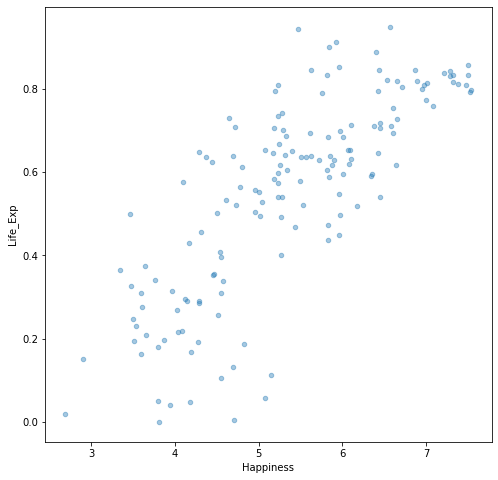

In [10]:
ax = plt.figure(figsize=(8,8)).gca()
dat.plot.scatter(x='Happiness', y = 'Life_Exp', ax=ax, alpha =.4)

In [12]:
def r_z(r): ## transform distribution
    return math.log((1 + r) / (1 - r)) / 2.0

def z_r(z): ## inverse transform distribution 
    e = math.exp(2 * z)
    return((e - 1) / (e + 1))

def r_conf_int(r, alpha, n):
    # Transform r to z space
    z = r_z(r)
    # Compute standard error and critcal value in z
    se = 1.0 / math.sqrt(n - 3)
    z_crit = ss.norm.ppf(1 - alpha/2)

    ## Compute CIs with transform to r
    lo = z_r(z - z_crit * se)
    hi = z_r(z + z_crit * se)
    return (lo, hi)

def correlation_sig(df, col1, col2):
    pearson_cor = ss.pearsonr(x = df[col1], y = dat[col2])
    conf_ints = r_conf_int(pearson_cor[0], 0.05, 1000)
    print('Correlation = %4.3f with CI of %4.3f to %4.3f and p_value %4.3e' 
        % (pearson_cor[0], conf_ints[0], conf_ints[1], pearson_cor[1]))
    
correlation_sig(dat, 'Happiness', 'Life_Exp')    

Correlation = 0.782 with CI of 0.757 to 0.805 and p_value 3.213e-33


In [13]:
#Since Correlation works best with normally distributed data, let's check for skewness.

Text(0.5, 0, 'Happiness')

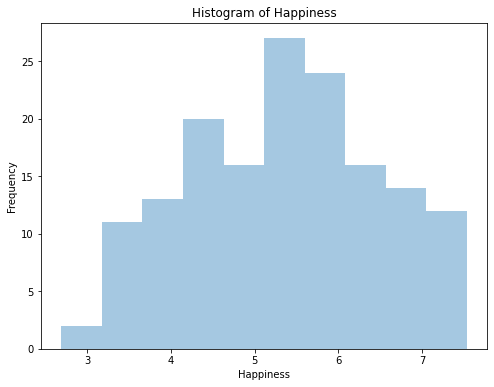

In [14]:
ax = plt.figure(figsize=(8, 6)).gca() # define axis
dat.Happiness.plot.hist(ax = ax, alpha = 0.4)
plt.title('Histogram of Happiness')
plt.xlabel('Happiness')

Text(0.5, 0, 'Life Expectancy')

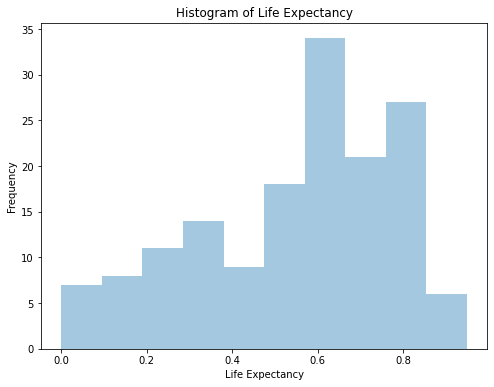

In [15]:
ax = plt.figure(figsize=(8, 6)).gca() # define axis
dat.Life_Exp.plot.hist(ax = ax, alpha = 0.4)
plt.title('Histogram of Life Expectancy')
plt.xlabel('Life Expectancy')

In [16]:
'''We see here that both variables are decently normally distributed, but life expectancy 
is possibly negative skewed (i.e., "skew left"). We can get a metric of the skew using the skewtest() 
function from the Scipy.Stats package:'''

'We see here that both variables are decently normally distributed, but life expectancy \nis possibly negative skewed (i.e., "skew left"). We can get a metric of the skew using the skewtest() \nfunction from the Scipy.Stats package:'

In [17]:
skew = ss.skewtest(dat.Happiness)
skew


SkewtestResult(statistic=0.05018342604501572, pvalue=0.9599762190117113)

In [18]:
skew = ss.skewtest(dat.Life_Exp)
skew

SkewtestResult(statistic=-2.8528836098343473, pvalue=0.0043324486370550416)

In [19]:
#We can see that Life_Exp has a negative skew. So let's reverse it.

In [20]:
dat['Life_Exp2']= max(dat.Life_Exp) + 1 - dat.Life_Exp

In [21]:
#now let's look at it

Text(0.5, 0, 'Reversed Life Expectancy')

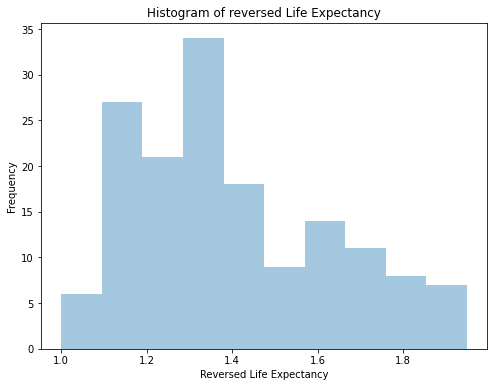

In [22]:
ax = plt.figure(figsize=(8, 6)).gca() # define axis
dat.Life_Exp2.plot.hist(ax = ax, alpha = 0.4)
plt.title('Histogram of reversed Life Expectancy')
plt.xlabel('Reversed Life Expectancy')

In [23]:
'''Now we can perform any number of operations. The square root is the most mild transformation. We 
can also take the natural log of every score (no values may be zero!). 
In general, these operations reduce big numbers more than small numbers and thus rein in the long tail. 
The Pandas apply method is used to apply the math.sqrt function to each element of Life_Exp2.'''

'Now we can perform any number of operations. The square root is the most mild transformation. We \ncan also take the natural log of every score (no values may be zero!). \nIn general, these operations reduce big numbers more than small numbers and thus rein in the long tail. \nThe Pandas apply method is used to apply the math.sqrt function to each element of Life_Exp2.'

Text(0.5, 0, 'Reversed Life Expectancy squared')

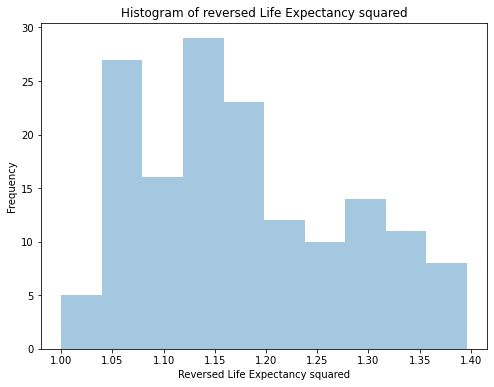

In [26]:
## Square the reversed variable
dat['Life_Expect2_sqrt'] = dat.Life_Exp2.apply(math.sqrt)

ax = plt.figure(figsize=(8, 6)).gca() # define axis
dat.Life_Expect2_sqrt.plot.hist(ax = ax, alpha = 0.4)
plt.title('Histogram of reversed Life Expectancy squared')
plt.xlabel('Reversed Life Expectancy squared')

In [27]:
## un-reverse the variable
dat['Life_Expect2']= max(dat.Life_Expect2_sqrt) + 1 - dat.Life_Expect2_sqrt

## compute correlation of new variable and test statistics
correlation_sig(dat, 'Happiness', 'Life_Expect2')  

Correlation = 0.786 with CI of 0.762 to 0.809 and p_value 7.978e-34


In [28]:
'''We see here the results barely changed. In this case, that wasn't really necessary because the 
variable was not that skewed to begin with. You will find, in many cases, that it 
is very helpful, however. In those cases, there are many online guides to data transformation.'''

"We see here the results barely changed. In this case, that wasn't really necessary because the \nvariable was not that skewed to begin with. You will find, in many cases, that it \nis very helpful, however. In those cases, there are many online guides to data transformation."

In [29]:
dat[['Happiness', 'Life_Exp', 'Generosity']].corr()

,Happiness,Life_Exp,Generosity
Happiness,1.000000,0.781951,0.155256
Life_Exp,0.781951,1.000000,0.063191
Generosity,0.155256,0.063191,1.000000


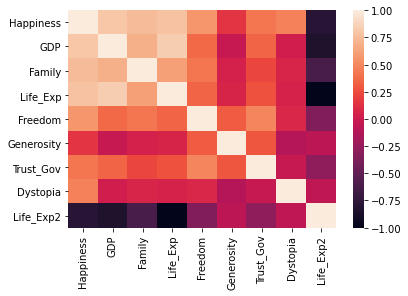

In [30]:
## Compute the correlation matrix
corrs = dat.drop(['Life_Expect2', 'Life_Expect2_sqrt'], axis = 1).corr()

## Create the hierarchical clustering model
dist = sch.distance.pdist(corrs)   # vector of pairwise distances using correlations
linkage = sch.linkage(dist, method='complete') # Compute the linkages for the clusters
ind = sch.fcluster(linkage, 0.5*dist.max(), 'distance')  # Apply the clustering algorithm

## Order the columns of the correlaton matrix according to the hierarchy
columns = [corrs.columns.tolist()[i] for i in list((np.argsort(ind)))]  # Order the names for the result
corrs_clustered = corrs.reindex(columns) ## Reindex the columns following the heirarchy 

## Plot a heat map of the clustered correlations
sns.heatmap(corrs_clustered, 
            xticklabels=corrs_clustered.columns.values,
            yticklabels=corrs_clustered.columns.values)

In [36]:
ind

array([1, 1, 1, 1, 2, 2, 2, 2, 3], dtype=int32)

In [31]:
'''Here we see there is a prominent cluster of happiness, family, life expectancy, and GDP. 
These are all highly inter-correlated. You can see this from the bright spot in the heat map.

Another Correlation Plot
With small number variables, it can be useful to display the correlation matrix with the numerical values.
The Pandas style.background_gradient() does just this:'''

'Here we see there is a prominent cluster of happiness, family, life expectancy, and GDP. \nThese are all highly inter-correlated. You can see this from the bright spot in the heat map.\n\nAnother Correlation Plot\nWith small number variables, it can be useful to display the correlation matrix with the numerical values.\nThe Pandas style.background_gradient() does just this:'

In [32]:
corrs_clustered

,Happiness,GDP,Family,Life_Exp,Freedom,Generosity,Trust_Gov,Dystopia,Life_Exp2
Happiness,1.000000,0.812469,0.752737,0.781951,0.570137,0.155256,0.429080,0.475355,-0.781951
GDP,0.812469,1.000000,0.688296,0.843077,0.369873,-0.019011,0.350944,0.024226,-0.843077
Family,0.752737,0.688296,1.000000,0.612080,0.424966,0.051693,0.231841,0.070506,-0.612080
Life_Exp,0.781951,0.843077,0.612080,1.000000,0.349827,0.063191,0.279752,0.054963,-1.000000
Freedom,0.570137,0.369873,0.424966,0.349827,1.000000,0.316083,0.499183,0.081926,-0.349827
Generosity,0.155256,-0.019011,0.051693,0.063191,0.316083,1.000000,0.294159,-0.116627,-0.063191
Trust_Gov,0.429080,0.350944,0.231841,0.279752,0.499183,0.294159,1.000000,-0.022755,-0.279752
Dystopia,0.475355,0.024226,0.070506,0.054963,0.081926,-0.116627,-0.022755,1.000000,-0.054963
Life_Exp2,-0.781951,-0.843077,-0.612080,-1.000000,-0.349827,-0.063191,-0.279752,-0.054963,1.000000


In [33]:
corrs_clustered.style.background_gradient().set_precision(2)

,Happiness,GDP,Family,Life_Exp,Freedom,Generosity,Trust_Gov,Dystopia,Life_Exp2
Happiness,1.00,0.81,0.75,0.78,0.57,0.16,0.43,0.48,-0.78
GDP,0.81,1.00,0.69,0.84,0.37,-0.02,0.35,0.02,-0.84
Family,0.75,0.69,1.00,0.61,0.42,0.05,0.23,0.07,-0.61
Life_Exp,0.78,0.84,0.61,1.00,0.35,0.06,0.28,0.05,-1.00
Freedom,0.57,0.37,0.42,0.35,1.00,0.32,0.50,0.08,-0.35
Generosity,0.16,-0.02,0.05,0.06,0.32,1.00,0.29,-0.12,-0.06
Trust_Gov,0.43,0.35,0.23,0.28,0.50,0.29,1.00,-0.02,-0.28
Dystopia,0.48,0.02,0.07,0.05,0.08,-0.12,-0.02,1.00,-0.05
Life_Exp2,-0.78,-0.84,-0.61,-1.00,-0.35,-0.06,-0.28,-0.05,1.00


In [38]:
'''The darker the color, the higher the correlation. The lightest colors are negative correlations.

Notice that several variables exhibit correlations quite close to 0. It is a good idea to see if these correlations are even significant.'''

'The darker the color, the higher the correlation. The lightest colors are negative correlations.\n\nNotice that several variables exhibit correlations quite close to 0. It is a good idea to see if these correlations are even significant.'

In [39]:
def correlation_sig2(df, col1, col2):
    pearson_cor = ss.pearsonr(x = df[col1], y = dat[col2]) 
    conf_ints = r_conf_int(pearson_cor[0], 0.05, 1000)
    print('Correlation with ' + col2 + ' = %4.3f with CI of %4.3f to %4.3f and p_value %4.3e' 
        % (pearson_cor[0], conf_ints[0], conf_ints[1], pearson_cor[1]))

def test_significance(df, col_list):
    cols = df.columns
    for col1 in col_list: 
        print('\n')
        print('Significance of correlations with ' + col1)
        for col2 in cols: 
            if(col1 != col2):
                correlation_sig2(df, col1, col2)  

test_cols = ['Trust_Gov', 'Generosity', 'Dystopia']
test_significance(dat, test_cols)



Significance of correlations with Trust_Gov
Correlation with Happiness = 0.429 with CI of 0.377 to 0.478 and p_value 2.538e-08
Correlation with GDP = 0.351 with CI of 0.295 to 0.404 and p_value 7.567e-06
Correlation with Family = 0.232 with CI of 0.172 to 0.290 and p_value 3.700e-03
Correlation with Life_Exp = 0.280 with CI of 0.222 to 0.336 and p_value 4.229e-04
Correlation with Freedom = 0.499 with CI of 0.451 to 0.544 and p_value 3.810e-11
Correlation with Generosity = 0.294 with CI of 0.236 to 0.350 and p_value 2.031e-04
Correlation with Dystopia = -0.023 with CI of -0.085 to 0.039 and p_value 7.787e-01
Correlation with Life_Exp2 = -0.280 with CI of -0.336 to -0.222 and p_value 4.229e-04
Correlation with Life_Expect2_sqrt = -0.291 with CI of -0.347 to -0.233 and p_value 2.364e-04
Correlation with Life_Expect2 = 0.291 with CI of 0.233 to 0.347 and p_value 2.364e-04


Significance of correlations with Generosity
Correlation with Happiness = 0.155 with CI of 0.094 to 0.215 and p_val

In [40]:
'''Using the correlation analysis, we have both learned to find clusters of relationships among data and to estimate individual correlations and test them for significance. If we had a specific variable we
wanted to study in greater detail, we could graduate to regression, which we will do in the next lab.'''

'Using the correlation analysis, we have both learned to find clusters of relationships among data and to estimate individual correlations and test them for significance. If we had a specific variable we\nwanted to study in greater detail, we could graduate to regression, which we will do in the next lab.'